# viewf

The notebook will investigate the `viewf.viewf.viewf` function and compare with the IPW version.

In [3]:
import collections

import numpy as np
from spatialnc import ipw
import matplotlib.pyplot as plt

from viewf.viewf import viewf, viewcalc, d2r
from viewf.horizon import horizon

class TestViewf():
    
    int_min = 0
    int_max = 2**16-1   # 16 bit images

    def __init__(self, nangles):
        
        self.nangles = nangles
        
        # input DEM
        infile = '../tests/Lakes/gold_ipw/gold_dem.ipw'
        d = ipw.IPW(infile)
        self.gold_dem = np.double(d.bands[0].data)
        self.spacing = d.bands[0].dline
        
        # 8 bit gradient
        infile = '../tests/Lakes/gold_ipw/gold_gradient8.ipw'
        d = ipw.IPW(infile)
        self.gold_slope = d.bands[0].data    # sin(slope)
        self.gold_aspect = d.bands[1].data   # radians

        # Viewf gold files
        self.gold_file = '../tests/Lakes/gold_ipw/viewf/viewf_8bit_16ang.ipw'
        d = ipw.IPW(self.gold_file)
        self.gold_svf_data = d.bands[0].data * 2
        self.gold_tcf_data = d.bands[1].data

        # to make a fair comparison, first convert the viewf to
        # integers then back using the 8 bit LQ
        # with viewf the float min/max are constant from 0-1
        self.float_min_svf = 1.0
        self.float_max_svf = 0.0
        self.float_min_tcf = 0.0
        self.float_max_tcf = 1.0
        self.int_min = 0
        self.int_max = 2**8-1 
        
#         self.run_viewf_ipw()
        self.run_viewf()
        
    def int_to_float_svf(self, x):
        return (self.float_max_svf - self.float_min_svf) * \
            (x / self.int_max) + self.float_min_svf
    
    def convert_horizon_to_ipw_and_back(self, horizon):
        """Convert the horizon image to 8 bit image and then back
        to mimic what hor1d is doing in viewf.sh

        Arguments:
            horizon {np.array} -- numpy array of horizon values
        """
        svf_int = ipw.map_fn(horizon, self.float_min_svf,
                             self.float_max_svf, self.int_min, self.int_max)
        svf_float = (self.float_max_svf - self.float_min_svf) * \
            (svf_int / self.int_max) + self.float_min_svf

        return svf_float
    
    def run_viewf_ipw(self):
        """Mimic what IPW's viewf.sh is doing. Each call to hor1d (horizon)
        outputs an 8 bit image that are then mux'd into a single image and
        passed to viewcalc with an 8 bit gradient image.
        
        https://github.com/USDA-ARS-NWRC/ipw/blob/2e802fc01000e0426c77a0c9b9959cfc807b2d65/src/bin/topocalc/viewf/viewf.sh#L174
        """

        Horizon = collections.namedtuple('Horizon', ['azimuth', 'hcos'])

        angles = np.linspace(-180, 180, num=self.nangles, endpoint=False)

        hcos = {}
        for angle in angles:
            h = horizon(angle, self.gold_dem, self.spacing)
            hcos[angle] = Horizon(
                d2r(angle),
                self.convert_horizon_to_ipw_and_back(h)
            )

        svf, tcf = viewcalc(self.gold_slope, self.gold_aspect, hcos)
        
        self.svf_float = self.convert_horizon_to_ipw_and_back(svf)
        
    def run_viewf(self):
        """Run the viewf function and compare with the gold file
        """

        svf, tcf = viewf(
            self.gold_dem,
            self.spacing,
            nangles=self.nangles,
            sin_slope=self.gold_slope,
            aspect=self.gold_aspect
        )
        
        self.svf = svf
        self.tcf = tcf

        # convert the numpy array from a float, to int and back
        self.svf_int = ipw.map_fn(self.svf, self.float_min_svf,
                           self.float_max_svf, self.int_min, self.int_max)
        self.svf_float = self.int_to_float_svf(self.svf_int)
        
        self.tcf_int = ipw.map_fn(self.tcf, self.float_min_tcf,
                           self.float_max_tcf, self.int_min, self.int_max)
#         self.tcf_float = self.int_to_float(self.tcf_int)
        
        
    def plot_svf(self):
        d = self.gold_svf_data - self.svf_float

        fig, ax = plt.subplots(2, 2, figsize = (15, 15))
        fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
        fig.suptitle('Sky View Factor {} nangles'.format(self.nangles))

        # IPW original
        im0 = ax[0, 0].imshow(self.gold_svf_data)
        ax[0, 0].set_title('IPW output')
        fig.colorbar(im0, ax=ax[0, 0])

        # horizon output
        im1 = ax[0, 1].imshow(self.svf_float)
        ax[0, 1].set_title('viewf output')
        fig.colorbar(im1, ax=ax[0, 1])

        # difference
        var_lim = max([abs(d.min()), abs(d.max())])
        im2 = ax[1, 0].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
        ax[1, 0].set_title('Difference, gold - new')
        fig.colorbar(im2, ax=ax[1, 0])

#         ax[1, 1].hist(d, bins=30)
#         ax[1, 1].set_title('Histogram')

        # remove the x and y ticks
        for a in ax.flatten()[:3]:
            a.set_xticks([])
            a.set_yticks([])

        plt.show()

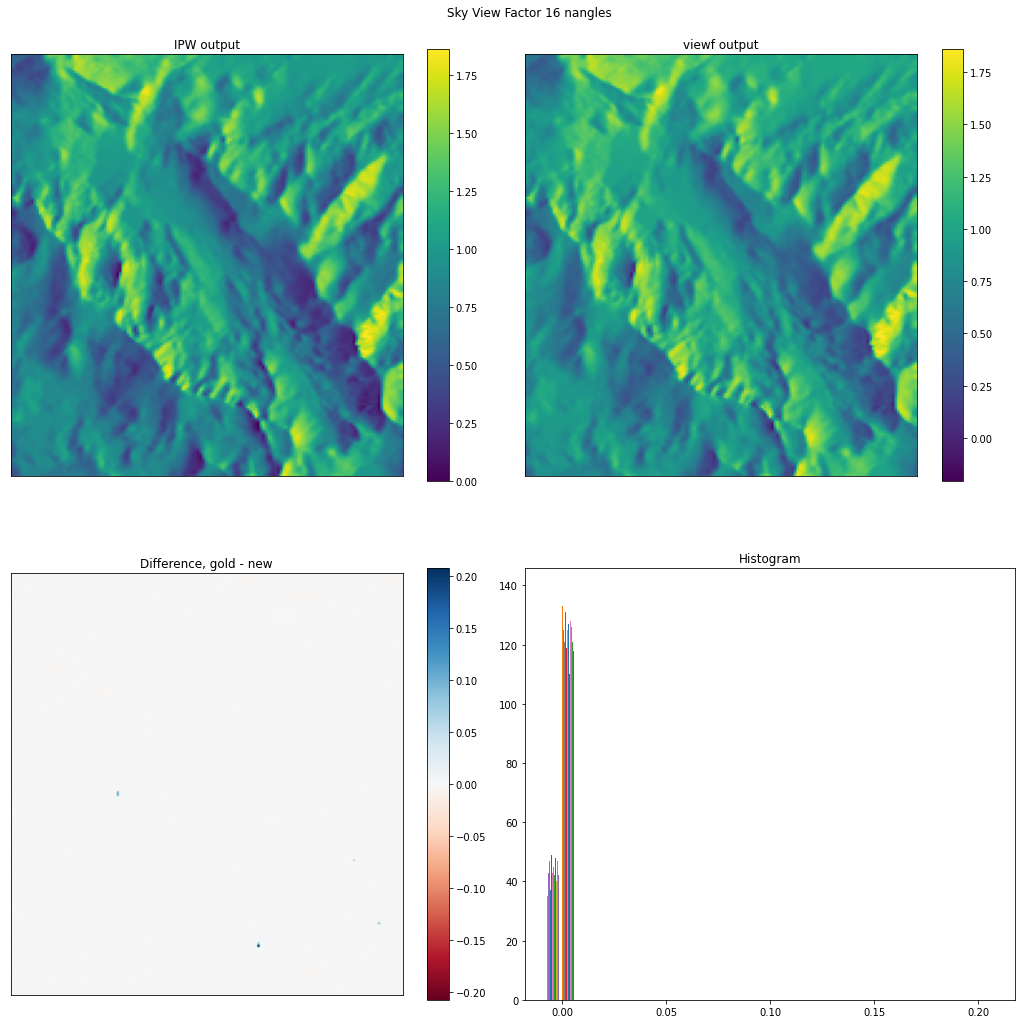

In [4]:
# viewf with 16 angles
v = TestViewf(16)
v.plot_svf()

# plt.imshow(v.gold_svf_data - v.svf_float)
# plt.colorbar()

# plt.imshow(v.gold_slope)
# plt.colorbar()